In this initial step, we load the **Wikipedia Movie Plots** dataset and perform a first inspection to understand its structure. The dataset contains ~35,000 movies, each described by fields such as title, release year, origin, director, cast, genre, and a plot summary.

In [ ]:
import pandas as pd
from collections import defaultdict, Counter
from itertools import combinations
import networkx as nx
import numpy as np
import random
from collections import Counter
import community as community_louvain
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_csv("wiki_movie_plots_deduped.csv")

# Display basic info
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("\nColumn names:")
print(df.columns.tolist())

# Preview the first 5 rows
df.head(10)

Number of rows: 34886
Number of columns: 8

Column names:
['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


Before constructing the movie–movie network, we apply filtering to ensure that the dataset contains meaningful and well-structured cast information. Since our network will connect movies that **share at least one cast member**, the quality and completeness of the *Cast* field directly affects the network’s connectivity.

**1. Remove movies with missing cast information**
Movies with `NaN` cast values cannot form edges in a cast-based network. These movies would become isolated nodes, so we remove them from the dataset.

**2. Filter movies by release year (keep movies from 1950 onward)**
Early films (1900–1940s) often have:
- Very limited cast lists  
- Inconsistent or incomplete metadata  
- Weak or no cast overlap with modern films 

In [ ]:
# Remove rows with missing cast information
df_clean = df.dropna(subset=["Cast"])

print("After removing NaN cast entries:")
print("Remaining movies:", len(df_clean))
print()

# Keep only movies released in or after 1950
df_clean = df_clean[df_clean["Release Year"] >= 1950]

print("After filtering by release year >= 1950:")
print("Remaining movies:", len(df_clean))
print()

# Preview the cleaned dataset
df_clean.head()

After removing NaN cast entries:
Remaining movies: 33464

After filtering by release year >= 1950:
Remaining movies: 27397



,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
5037,1950,8 Ball Bunny,American,Chuck Jones,Looney Tunes,animation,https://en.wikipedia.org/wiki/8_Ball_Bunny,The Brooklyn Ice Palace shuts down after the I...
5038,1950,711 Ocean Drive,American,Joseph M. Newman,"Edmond O'Brien, Joanne Dru, Dorothy Patrick",crime drama,https://en.wikipedia.org/wiki/711_Ocean_Drive,Knowing how much telephone repairman Mal Grang...
5039,1950,Abbott and Costello in the Foreign Legion,American,Charles Lamont,"Abbott and Costello, Patricia Medina",comedy,https://en.wikipedia.org/wiki/Abbott_and_Coste...,Bud Jones (Bud Abbott) and Lou Hotchkiss (Lou ...
5040,1950,The Admiral Was a Lady,American,Albert S. Rogell,"Edmond O'Brien, Wanda Hendrix, Steve Brodie",comedy,https://en.wikipedia.org/wiki/The_Admiral_Was_...,"After the end of World War II, Jean Madison (W..."
5041,1950,All About Eve,American,Joseph L. Mankiewicz,"Bette Davis, Anne Baxter, Gary Merrill, Celest...",drama,https://en.wikipedia.org/wiki/All_About_Eve,Margo Channing (Bette Davis) is one of the big...


To construct a movie–movie network where edges represent shared cast members, we first need to convert the `Cast` column from a single text string into a structured list of actor names for each movie.


1. **Split cast strings into lists of names**
   - The `Cast` column currently contains comma-separated names (e.g., `"Actor A, Actor B, Actor C"`).
   - We split these strings on commas to obtain a Python list of actors for each movie.

2. **Clean and standardize actor names**
   - Strip leading/trailing whitespace around names.
   - Remove any empty strings created during splitting.

3. **Compute basic statistics about cast sizes**
   - For each movie, compute the number of cast members.
   - Inspect the distribution of cast sizes to understand how many actors typically appear in a movie and whether there are many movies with only 1 actor listed.

At this stage, we do not filter out movies with small casts yet. Instead, we first explore the data and later decide whether an additional filter (e.g., at least 2 cast members) is necessary based on network sparsity.

In [ ]:
# Split the Cast string into a list of actor names

def split_and_clean_cast(cast_str):
    # Safety check: if for some reason we get a non-string, return empty list
    if not isinstance(cast_str, str):
        return []
    # Split on commas
    names = cast_str.split(',')
    # Strip whitespace and keep only non-empty names
    names = [name.strip() for name in names if name.strip() != ""]
    return names

df_clean["cast_list"] = df_clean["Cast"].apply(split_and_clean_cast)

# Compute the number of cast members per movie
df_clean["num_cast"] = df_clean["cast_list"].apply(len)

# Inspect basic statistics about cast sizes
print("Cast size statistics (number of actors per movie):")
print(df_clean["num_cast"].describe())

# Preview a few rows to verify the transformation
df_clean[["Title", "Release Year", "cast_list", "num_cast"]].head(10)

Cast size statistics (number of actors per movie):
count    27397.000000
mean         3.597876
std          2.423985
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         53.000000
Name: num_cast, dtype: float64


,Title,Release Year,cast_list,num_cast
5037,8 Ball Bunny,1950,[Looney Tunes],1
5038,711 Ocean Drive,1950,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",3
5039,Abbott and Costello in the Foreign Legion,1950,"[Abbott and Costello, Patricia Medina]",2
5040,The Admiral Was a Lady,1950,"[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",3
5041,All About Eve,1950,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",7
5042,American Guerrilla in the Philippines,1950,"[Tyrone Power, Micheline Presle]",2
5043,Armored Car Robbery,1950,"[Charles McGraw, Adele Jergens, William Talman]",3
5044,The Asphalt Jungle,1950,"[Sterling Hayden, Louis Calhern, Sam Jaffe, Ja...",5
5045,At War with the Army,1950,"[Dean Martin, Jerry Lewis, Polly Bergen]",3
5046,Atom Man vs. Superman,1950,"[Kirk Alyn, Lyle Talbot, Noel Neill]",3


To ensure that the network contains meaningful edges, we remove movies that have too few cast members. Movies with zero cast members cannot form any connections, and movies with only one cast member can connect only if that actor appears elsewhere.

To improve the connectivity and interpretability of the network, we apply the following filter:

- **Keep only movies with at least 2 cast members (`num_cast` ≥ 2)**

In [ ]:
# Filter movies with at least 2 cast members

before = len(df_clean)
df_clean = df_clean[df_clean["num_cast"] >= 2]
after = len(df_clean)

print(f"Movies before filtering: {before}")
print(f"Movies after filtering (>= 2 cast members): {after}")
print(f"Movies removed: {before - after}")

Movies before filtering: 27397
Movies after filtering (>= 2 cast members): 25203
Movies removed: 2194


In [46]:
df_clean

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,cast_list,num_cast
5038,1950,711 Ocean Drive,American,Joseph M. Newman,"Edmond O'Brien, Joanne Dru, Dorothy Patrick",crime drama,https://en.wikipedia.org/wiki/711_Ocean_Drive,Knowing how much telephone repairman Mal Grang...,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",3
5039,1950,Abbott and Costello in the Foreign Legion,American,Charles Lamont,"Abbott and Costello, Patricia Medina",comedy,https://en.wikipedia.org/wiki/Abbott_and_Coste...,Bud Jones (Bud Abbott) and Lou Hotchkiss (Lou ...,"[Abbott and Costello, Patricia Medina]",2
5040,1950,The Admiral Was a Lady,American,Albert S. Rogell,"Edmond O'Brien, Wanda Hendrix, Steve Brodie",comedy,https://en.wikipedia.org/wiki/The_Admiral_Was_...,"After the end of World War II, Jean Madison (W...","[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",3
5041,1950,All About Eve,American,Joseph L. Mankiewicz,"Bette Davis, Anne Baxter, Gary Merrill, Celest...",drama,https://en.wikipedia.org/wiki/All_About_Eve,Margo Channing (Bette Davis) is one of the big...,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",7
5042,1950,American Guerrilla in the Philippines,American,Fritz Lang,"Tyrone Power, Micheline Presle",war,https://en.wikipedia.org/wiki/American_Guerril...,"In April 1942 in the Philippines, an American ...","[Tyrone Power, Micheline Presle]",2
...,...,...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,"Director: Russell Crowe\nCast: Russell Crowe, ...",unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ...","[Director: Russell Crowe\nCast: Russell Crowe,...",5
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...","[Ahmet Kural, Murat Cemcir]",2
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...","[Ata Demirer, Tuvana Türkay, Ülkü Duru]",3
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,"[YouTubers Shanna Malcolm, Shira Lazar, Sara F...",3


We now construct the movie–movie network where:

- **Nodes** = movies  
- **Edges** = undirected links between movies that share at least one cast member  
- **Edge weight** = number of shared cast members 

In [ ]:
# Build the movie–movie edges based on shared cast

# Give each movie a unique integer ID
df_clean = df_clean.reset_index(drop=True)
df_clean["movie_id"] = df_clean.index

print("Number of movies (nodes):", len(df_clean))

# Build actor -> list of movie_ids mapping
actor_to_movies = defaultdict(list)

for _, row in df_clean.iterrows():
    mid = row["movie_id"]
    for actor in row["cast_list"]:
        actor_to_movies[actor].append(mid)

print("Number of unique actors:", len(actor_to_movies))

# Build edge weights: for each actor, connect all pairs of their movies
edge_weights = Counter()

for movies in actor_to_movies.values():
    # Only actors that appear in at least 2 movies can create edges
    if len(movies) < 2:
        continue
    
    # Remove duplicates and sort
    movies = sorted(set(movies))
    
    # Create all movie–movie pairs for this actor
    for m1, m2 in combinations(movies, 2):
        edge_weights[(m1, m2)] += 1

print("Number of unique movie–movie pairs (edges):", len(edge_weights))

# Convert edge weights to a DataFrame
edges = [
    {"source": m1, "target": m2, "weight": w}
    for (m1, m2), w in edge_weights.items()
]

edges_df = pd.DataFrame(edges)

print("Preview of edges:")
print(edges_df.head())
print("Total edges:", len(edges_df))

Number of movies (nodes): 25203
Number of unique actors: 26368
Number of unique movie–movie pairs (edges): 793746
Preview of edges:
   source  target  weight
0       0       2       1
1       0      10       1
2       0      14       1
3       0      44       1
4       0     380       1
Total edges: 793746


In [48]:
# Count number of movies per genre
genre_counts = df_clean["Genre"].value_counts()

print("Number of movies per genre:")
print(genre_counts)

# Optional: convert to DataFrame for easier visualization
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ["Genre", "Count"]

genre_counts_df.head(20)

Number of movies per genre:
Genre
unknown                                    4767
drama                                      4087
comedy                                     2993
action                                      990
horror                                      919
                                           ... 
science fiction / animation / adventure       1
action / mystery / crime                      1
history / war                                 1
comedy / action / sci-fi / animation          1
adventure, romance, fantasy film              1
Name: count, Length: 1932, dtype: int64


,Genre,Count
0,unknown,4767
1,drama,4087
2,comedy,2993
3,action,990
4,horror,919
5,romance,805
6,thriller,796
7,western,557
8,crime drama,393
9,crime,356


Now that we have:
- A cleaned list of movies (`df_clean`), each with a `movie_id`
- A weighted edge list (`edges_df`) where each row represents two movies that share actors

We can construct the full movie–movie network.

### Network structure:
- **Nodes**: movie_id (plus attributes: title, year, cast list, etc.)
- **Edges**: undirected links between movies
- **Weight**: how many cast members the two movies share

In [ ]:
# Build the full NetworkX graph

print("Building graph...")

# Initialize an undirected graph
G = nx.Graph()

# Add all movie nodes with attributes
for _, row in df_clean.iterrows():
    G.add_node(
        row["movie_id"],
        title=row["Title"],
        year=row["Release Year"],
        genre=row["Genre"],
        director=row["Director"],
        cast=row["cast_list"],
        origin=row['Origin/Ethnicity'],
        plot=row['Plot'],
        num_cast=row["num_cast"]
    )

print("Nodes added:", G.number_of_nodes())

# Add weighted edges (movie–movie shared cast)
for _, edge in edges_df.iterrows():
    G.add_edge(
        int(edge["source"]),
        int(edge["target"]),
        weight=int(edge["weight"])
    )

print("Edges added:", G.number_of_edges())

# Basic sanity check
print("\nGraph construction complete!")
print(f"Is graph directed? {G.is_directed()}")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

# Extract largest connected component (LCC)
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

print("\nLargest Connected Component:")
print("LCC nodes:", G_lcc.number_of_nodes())
print("LCC edges:", G_lcc.number_of_edges())

# Optionally inspect a random node
sample_node = next(iter(G_lcc.nodes()))
print("\nExample LCC node attributes:", G_lcc.nodes[sample_node])

Building graph...
Nodes added: 25203
Edges added: 793746

Graph construction complete!
Is graph directed? False
Total nodes: 25203
Total edges: 793746

Largest Connected Component:
LCC nodes: 24060
LCC edges: 793433

Example LCC node attributes: {'title': '711 Ocean Drive', 'year': 1950, 'genre': 'crime drama', 'director': 'Joseph M. Newman', 'cast': ["Edmond O'Brien", 'Joanne Dru', 'Dorothy Patrick'], 'origin': 'American', 'plot': 'Knowing how much telephone repairman Mal Granger (Edmond O\'Brien) likes to bet on the horses, small-time bookmaker Chippie Evans (Sammy White) proposes a scheme in which Granger\'s technical expertise would provide gangster Vince Walters (Barry Kelley) with race results in advance.\nGranger accepts and also takes an interest in Walters\' attractive assistant, Trudy (Dorothy Patrick), but she is arrested. Granger\'s new method of getting track information to the bookies makes him invaluable. He threatens to cut Walters off unless he is made a 20% partner. W

Analyzing the properties of the largest connected component (LCC) of the movie–movie network will give us a global view of how movies are connected through shared cast members.

For the LCC we will compute:

- Number of nodes and edges  
- Degree and weighted degree statistics  
- Network density  
- Average clustering coefficient  
- Approximate average shortest path length  

These measures help us understand how dense the network is, whether there are hub movies with many shared cast connections, and how “small-world” the movie collaboration network is.

In [ ]:
print("LCC nodes:", G_lcc.number_of_nodes())
print("LCC edges:", G_lcc.number_of_edges())

degrees = dict(G_lcc.degree())
w_degrees = dict(G_lcc.degree(weight="weight"))

deg_values = np.array(list(degrees.values()))
wdeg_values = np.array(list(w_degrees.values()))

print("\nDegree statistics:")
print("  min:", deg_values.min())
print("  max:", deg_values.max())
print("  mean:", deg_values.mean())
print("  median:", np.median(deg_values))

print("\nWeighted degree (strength) statistics:")
print("  min:", wdeg_values.min())
print("  max:", wdeg_values.max())
print("  mean:", wdeg_values.mean())
print("  median:", np.median(wdeg_values))

density = nx.density(G_lcc)
print("\nDensity of LCC:", density)

avg_clustering = nx.average_clustering(G_lcc, weight=None)
print("Average clustering coefficient:", avg_clustering)

# Approximate Average Shortest Path Length (sampling) 

def approximate_aspl(G, sample_size=200, seed=42):
    """
    Approximate the average shortest path length by sampling a subset of nodes.
    This is much faster than computing all-pairs shortest paths.
    """
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sample_size = min(sample_size, len(nodes))
    samples = rng.sample(nodes, sample_size)

    lengths = []
    for n in samples:
        sp_lengths = nx.single_source_shortest_path_length(G, n)
        lengths.extend(sp_lengths.values())

    return float(np.mean(lengths))

approx_aspl = approximate_aspl(G_lcc, sample_size=200)
print("Approximate average shortest path length:", approx_aspl)

LCC nodes: 24060
LCC edges: 793433

Degree statistics:
  min: 1
  max: 517
  mean: 65.95453034081463
  median: 48.0

Weighted degree (strength) statistics:
  min: 1
  max: 627
  mean: 68.7260182876143
  median: 49.0

Density of LCC: 0.0027413662388634037
Average clustering coefficient: 0.5107265300871476
Approximate average shortest path length: 4.030713216957606


We now perform community detection on the unweighted version of the movie–movie network. 
This helps us identify groups of movies that are densely connected through shared cast members.

### Why unweighted?
Using an unweighted graph focuses on the existence of shared-cast relationships rather than the number of shared actors. 
This simplifies the community structure and avoids excessive influence from movies with unusually large casts.

We use the **Louvain algorithm**, a modularity-based community detection method that is fast and effective for large networks.

In [ ]:
#Build unweighted LCC graph

print("Building unweighted LCC graph...")

G_unweighted = nx.Graph()

# Add nodes (with attributes preserved)
G_unweighted.add_nodes_from(G_lcc.nodes(data=True))

# Add unweighted edges (ignore weights)
G_unweighted.add_edges_from(G_lcc.edges())

print("Nodes:", G_unweighted.number_of_nodes())
print("Edges:", G_unweighted.number_of_edges())

random.seed(42) # to get the same results each time

# Louvain community detection
print("\nRunning Louvain community detection...")

partition = community_louvain.best_partition(G_unweighted)

# Save detected community for each node
nx.set_node_attributes(G_unweighted, partition, "community")

# Compute modularity score
modularity_value = community_louvain.modularity(partition, G_unweighted)

print("\nLouvain community detection complete!")
print("Modularity:", modularity_value)


# Community size summary
community_sizes = Counter(partition.values())

print("\nNumber of communities:", len(community_sizes))

print("\nTop 10 largest communities:")
for com, size in community_sizes.most_common(10):
    print(f"  Community {com}: {size} movies")



print("\nSmallest 10 communities:")
for com, size in sorted(community_sizes.items(), key=lambda x: x[1])[:10]:
    print(f"  Community {com}: {size} movies")

Building unweighted LCC graph...
Nodes: 24060
Edges: 793433

Running Louvain community detection...

Louvain community detection complete!
Modularity: 0.7046922282662511

Number of communities: 32

Top 10 largest communities:
  Community 1: 8167 movies
  Community 0: 5346 movies
  Community 26: 4185 movies
  Community 16: 2812 movies
  Community 11: 955 movies
  Community 31: 825 movies
  Community 18: 768 movies
  Community 19: 324 movies
  Community 4: 191 movies
  Community 30: 134 movies

Smallest 10 communities:
  Community 2: 3 movies
  Community 6: 3 movies
  Community 9: 3 movies
  Community 15: 3 movies
  Community 17: 3 movies
  Community 23: 3 movies
  Community 24: 3 movies
  Community 27: 3 movies
  Community 29: 3 movies
  Community 5: 4 movies


Now that each movie has been assigned to a Louvain community, we examine how these structural communities relate to movie genres. Communities detected from the network represent *cast-sharing clusters*.  
Genres represent *thematic categories*.

By comparing the two, we can explore:
- whether communities correspond to genres,
- which genres dominate each community,
- whether some communities represent specific regions or time periods instead of genre,
- whether community structure reveals hidden patterns not visible from genres alone.

In [ ]:
# Create DataFrame mapping movie_id -> (community, genre)
community_genre_df = pd.DataFrame({
    "movie_id": list(G_unweighted.nodes()),
    "community": [G_unweighted.nodes[n]["community"] for n in G_unweighted.nodes()],
    "genre": [G_unweighted.nodes[n]["genre"] for n in G_unweighted.nodes()]
})

# Replace NaN or empty genres
community_genre_df["genre"] = community_genre_df["genre"].fillna("Unknown")

# Group by community and count genres
community_genre_counts = (
    community_genre_df
    .groupby(["community", "genre"])
    .size()
    .reset_index(name="count")
)

# Compute top 5 genres for each community
top_genres_per_comm = (
    community_genre_counts
    .sort_values(["community", "count"], ascending=[True, False])
    .groupby("community")
    .head(5)
)

# Also compute community sizes
community_sizes_df = (
    community_genre_df["community"]
    .value_counts()
    .rename_axis("community")
    .reset_index(name="community_size")
)

# Merge sizes into top genres
top_genres_per_comm = top_genres_per_comm.merge(
    community_sizes_df, on="community", how="left"
)

# Add percentage of genre inside community
top_genres_per_comm["percentage"] = (
    top_genres_per_comm["count"] / top_genres_per_comm["community_size"] * 100
).round(2)

# Sort nicely
top_genres_per_comm = top_genres_per_comm.sort_values(
    ["community", "count"], ascending=[True, False]
)

top_genres_per_comm.head(10)

,community,genre,count,community_size,percentage
0,0,drama,1112,5346,20.80
1,0,comedy,874,5346,16.35
2,0,western,486,5346,9.09
3,0,horror,243,5346,4.55
4,0,adventure,239,5346,4.47
5,1,drama,1635,8167,20.02
6,1,comedy,1448,8167,17.73
7,1,unknown,602,8167,7.37
8,1,horror,435,8167,5.33
9,1,thriller,386,8167,4.73


In this step below we characterize the Louvain communities using movie metadata:

- **Top actors** in each community (who appear in the most movies)
- **Top directors** per community
- **Genre distribution** inside each community
- **Origin/Ethnicity distribution**
- **Release year distribution**

We then use simple visualizations (bar plots and histograms) to explore one community at a time.
This helps us interpret what each community represents (e.g., Hollywood cluster, Bollywood, Hong Kong cinema, early films, etc.) and choose which communities to study further with text analysis.

In [ ]:
# Build a DataFrame with all movie-level info from the graph + original df
nodes_rows = []

# Make a quick lookup from movie_id -> origin/ethnicity
origin_lookup = df_clean.set_index("movie_id")["Origin/Ethnicity"].to_dict()

for movie_id, data in G_unweighted.nodes(data=True):
    nodes_rows.append({
        "movie_id": movie_id,
        "community": data["community"],
        "title": data["title"],
        "year": data["year"],
        "genre": data["genre"] if data["genre"] is not None else "unknown",
        "director": data["director"],
        "cast": data["cast"],
        "origin": origin_lookup.get(movie_id, "Unknown"),
        'plot': data['plot']
    })

nodes_df = pd.DataFrame(nodes_rows)

nodes_df.head(10)

,movie_id,community,title,year,genre,director,cast,origin,plot
0,0,0,711 Ocean Drive,1950,crime drama,Joseph M. Newman,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",American,Knowing how much telephone repairman Mal Grang...
1,1,0,Abbott and Costello in the Foreign Legion,1950,comedy,Charles Lamont,"[Abbott and Costello, Patricia Medina]",American,Bud Jones (Bud Abbott) and Lou Hotchkiss (Lou ...
2,2,0,The Admiral Was a Lady,1950,comedy,Albert S. Rogell,"[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",American,"After the end of World War II, Jean Madison (W..."
3,3,0,All About Eve,1950,drama,Joseph L. Mankiewicz,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",American,Margo Channing (Bette Davis) is one of the big...
4,4,0,American Guerrilla in the Philippines,1950,war,Fritz Lang,"[Tyrone Power, Micheline Presle]",American,"In April 1942 in the Philippines, an American ..."
5,5,0,Armored Car Robbery,1950,film noir,Richard Fleischer,"[Charles McGraw, Adele Jergens, William Talman]",American,Mastermind Dave Purvis (William Talman) is a p...
6,6,0,The Asphalt Jungle,1950,film noir,John Huston,"[Sterling Hayden, Louis Calhern, Sam Jaffe, Ja...",American,"When criminal mastermind Erwin ""Doc"" Riedensch..."
7,7,0,At War with the Army,1950,musical comedy,Hal Walker,"[Dean Martin, Jerry Lewis, Polly Bergen]",American,The film is set at a United States Army base i...
8,9,0,The Avengers,1950,adventure,John H. Auer,"[Adele Mara, John Carroll]",American,"In 17th-century colonial Argentina, while tryi..."
9,10,0,Backfire,1950,crime thriller,Vincent Sherman,"[Edmond O'Brien, Virginia Mayo, Gordon MacRae]",American,Bob Corey (Gordon MacRae) is an American soldi...


In [95]:
def explore_community(comm_id, top_n=10):
    """
    Visual exploration of one community:
    - top actors
    - top directors
    - top genres
    - top origins
    - release year histogram
    """
    df_comm = nodes_df[nodes_df["community"] == comm_id].copy()
    print(f"Community {comm_id} — number of movies: {len(df_comm)}")

    
    # Top actors
    
    all_actors = []
    for cast_list in df_comm["cast"]:
        all_actors.extend(cast_list)

    actor_counts = Counter(all_actors)
    top_actors = pd.DataFrame(actor_counts.most_common(top_n),
                              columns=["actor", "count"])

    print("\nTop actors in community:")
    display(top_actors)

    plt.figure(figsize=(8, 4))
    plt.bar(top_actors["actor"], top_actors["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top {top_n} actors")
    plt.tight_layout()
    plt.show()

    
    # Top directors
    
    all_directors = []
    for d in df_comm["director"]:
        if isinstance(d, str):
            all_directors.extend([x.strip() for x in d.split(",") if x.strip()])

    director_counts = Counter(all_directors)
    top_directors = pd.DataFrame(director_counts.most_common(top_n),
                                 columns=["director", "count"])

    print("\nTop directors in community:")
    display(top_directors)

    plt.figure(figsize=(8, 4))
    plt.bar(top_directors["director"], top_directors["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top {top_n} directors")
    plt.tight_layout()
    plt.show()

    
    # Top genres
    
    genre_counts = df_comm["genre"].fillna("unknown").value_counts().head(top_n)
    genre_df = genre_counts.reset_index()
    genre_df.columns = ["genre", "count"]

    print("\nTop genres in community:")
    display(genre_df)

    plt.figure(figsize=(6, 4))
    plt.bar(genre_df["genre"], genre_df["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top genres")
    plt.tight_layout()
    plt.show()

    
    # Top origins
    
    origin_counts = df_comm["origin"].fillna("Unknown").value_counts().head(top_n)
    origin_df = origin_counts.reset_index()
    origin_df.columns = ["origin", "count"]

    print("\nTop origins in community:")
    display(origin_df)

    plt.figure(figsize=(6, 4))
    plt.bar(origin_df["origin"], origin_df["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top origins/ethnicities")
    plt.tight_layout()
    plt.show()

    
    # Release year distribution
    
    plt.figure(figsize=(7, 4))
    df_comm["year"].hist(bins=20)
    plt.xlabel("Release year")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Release year distribution")
    plt.tight_layout()
    plt.show()

Community 28 — number of movies: 78

Top actors in community:


,actor,count
0,Rémy Girard,15
1,Patrick Huard,10
2,Roy Dupuis,8
3,Gilbert Sicotte,6
4,Marc Messier,5
5,Germain Houde,4
6,Louise Portal,4
7,Pierre Curzi,4
8,Serge Thériault,4
9,Fanny Mallette,4


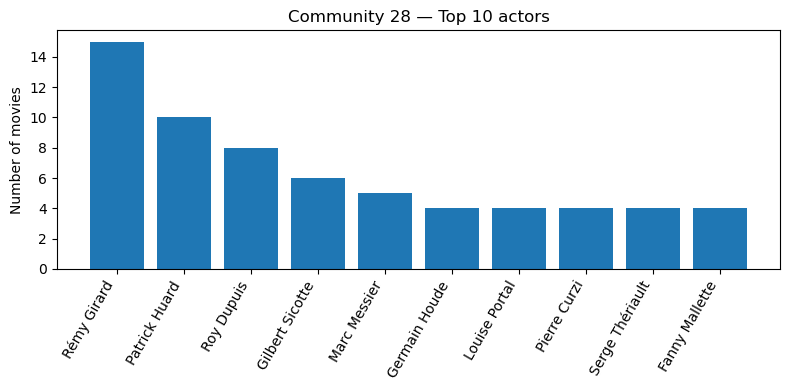


Top directors in community:


,director,count
0,Xavier Dolan,5
1,Jean Beaudin,3
2,Léa Pool,3
3,Denys Arcand,3
4,Jean-Marc Vallée,3
5,Jean-Claude Lauzon,2
6,Louis Saïa,2
7,Charles Binamé,2
8,Louise Archambault,2
9,Philippe Falardeau,2


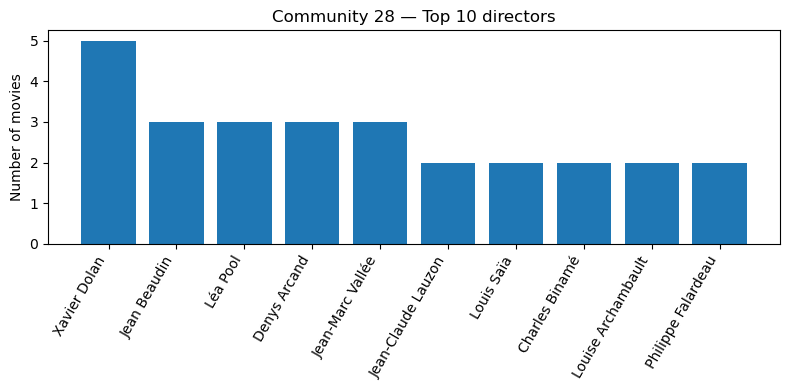


Top genres in community:


,genre,count
0,drama,39
1,comedy,9
2,"comedy, drama",4
3,crime drama,3
4,family drama,3
5,historical drama,2
6,thriller,2
7,docudrama,1
8,"drama, thriller",1
9,"comedy, crime",1


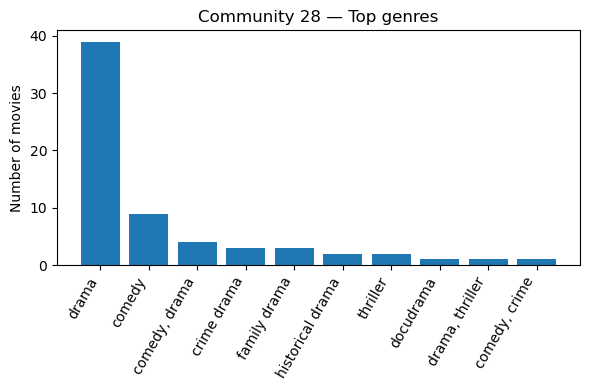


Top origins in community:


,origin,count
0,Canadian,77
1,Russian,1


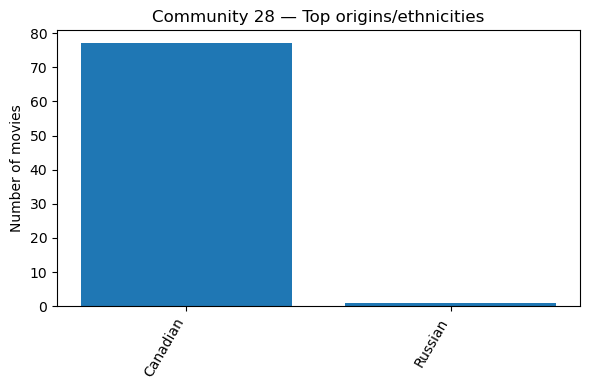

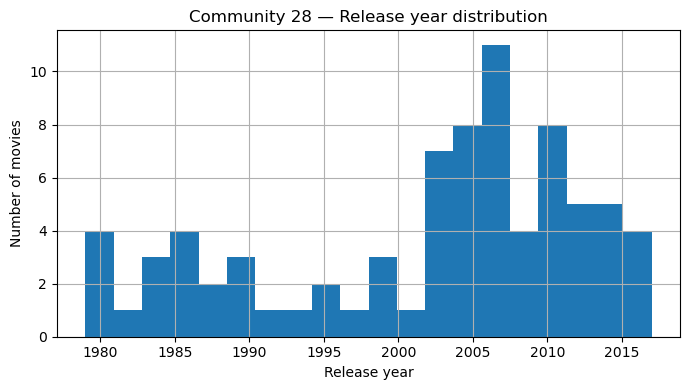

In [ ]:
explore_community(28) # Choose a community ID you are interested in 

So far, we constructed and explored a large-scale **movie co-cast network** using the Wikipedia Movie Plots dataset. After performing data cleaning, filtering, and preprocessing of cast lists, we built an undirected graph where movies are connected if they share at least one actor. Focusing on the **Largest Connected Component** (≈24k movies), we computed core network statistics such as degree distribution, clustering coefficient, density, and average shortest path length, confirming that the network is sparse but highly clustered and displays strong community structure.

Using the Louvain algorithm, we discovered **29 meaningful communities** with high modularity (≈0.70), indicating well-defined clusters.

___

# Network Analysis

This part of the notebook focuses on understanding the properties of the detected communities, including what we can learn from the content of the plots of the movies belonging to the communities. 

The analysis consists of:
- general overview of the communities
- wordclouds
- sentiment analysis

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt') 
import re
import requests
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zofialenarczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Network Degrees and Dataset Analysis

First, let's see what kind of movies are the most connected and least connected. We take the top nodes with the highest degree and the top nodes with the lowest degree to see what characterizes these two groups

In [ ]:
G = G_lcc.copy()

In [ ]:
high_num = 15
low_num = 15

degree_dict = dict(G.degree())
sorted_by_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
top_highest = sorted_by_degree[:high_num]

# Top highest degree nodes
highest_data = []
for movie_id, degree in top_highest:
    node_data = G.nodes[movie_id]
    highest_data.append({
        "movie_id": movie_id,
        "degree": degree,
        "title": node_data['title'],
        "year": node_data['year'],
        "genre": node_data['genre'],
        "director": node_data['director'],
        "num_cast": node_data['num_cast']
    })

df_highest = pd.DataFrame(highest_data)

# Top lowest degree nodes
lowest_degree = [item for item in sorted_by_degree if item[1] > 0][-low_num:]

lowest_data = []
for movie_id, degree in reversed(lowest_degree):
    node_data = G.nodes[movie_id]
    lowest_data.append({
        "movie_id": movie_id,
        "degree": degree,
        "title": node_data['title'],
        "year": node_data['year'],
        "genre": node_data['genre'],
        "director": node_data['director'],
        "num_cast": node_data['num_cast']
    })

df_lowest = pd.DataFrame(lowest_data)

print("Top nodes with highest degree:")
display(df_highest)

print("\nTop nodes with lowest degree:")
display(df_lowest)

Top nodes with highest degree:


,movie_id,degree,title,year,genre,director,num_cast
0,6366,517,Short Cuts,1993,drama,Robert Altman,22
1,16888,505,Naseeb,1981,"action, comedy, romance",Manmohan Desai,13
2,10428,469,"Butler, TheThe Butler",2013,drama,Lee Daniels,15
3,4720,456,Cannonball Run II,1984,comedy,Hal Needham,10
4,3900,452,A Bridge Too Far,1977,unknown,Richard Attenborough,12
5,21838,451,Panchathanthiram,2002,unknown,K. S. Ravikumar,9
6,10393,449,Anchorman 2: The Legend Continues,2013,comedy,Adam McKay,33
7,18186,448,Delhi-6,2009,"romance, drama",Rakeysh Omprakash Mehra,10
8,17119,441,Karma,1986,"action, drama",Subhash Ghai,10
9,18071,434,Dus Kahaniyaan,2007,drama,Sanjay Gupta,16



Top nodes with lowest degree:


,movie_id,degree,title,year,genre,director,num_cast
0,25193,1,Once Upon a Time in Anatolia,2011,drama,Nuri Bilge Ceylan,2
1,25161,1,Yahşi Batı,2010,comedy,Ömer Faruk Sorak,2
2,25119,1,The Way,2017,unknown,Jung In-bong,3
3,25108,1,Misbehavior,2017,unknown,Kim Tae-yong,2
4,25054,1,Alive,2015,unknown,Park Jung-bum,2
5,25036,1,The Cat Funeral,2015,unknown,Lee Jong-hoon,2
6,25035,1,Casa Amor: Exclusive for Ladies,2015,unknown,Jung Bum-shik,2
7,25028,1,Late Spring,2014,unknown,Cho Geun-hyun,3
8,25027,1,Set Me Free,2014,unknown,Kim Tae-yong,2
9,25005,1,Santa Barbara,2014,unknown,David Cho,2


The most connected movies are dominated by the drama genre, what is somewhat expected as this genre is the second most frequent genre after the unknown. Also these movies have quite numerous casts.

The least connected nodes are more difficult to analyze in this way, as there are many nodes with degree 1, but it can easily noticed that the number of cast members for these movies is rather low and all the listed movies are relatively new compared to the full dataset range (all of them are released after 2010).

To get a better understanding, we analyze the basic information about all the nodes with degree equal 1.

In [ ]:
# Filter nodes with degree = 1
degree_1_nodes = [node for node, deg in degree_dict.items() if deg == 1]

degree_1_data = []
for node_id in degree_1_nodes:
    node_data = G.nodes[node_id]
    degree_1_data.append({
        "movie_id": node_id,
        "title": node_data['title'],
        "year": node_data['year'],
        "genre": node_data['genre'],
        "origin": node_data['origin'],
        "num_cast": node_data['num_cast']
    })

df_degree_1 = pd.DataFrame(degree_1_data)

print(f"Total nodes with degree 1: {len(df_degree_1)}")

# most common genre
most_common_genre = df_degree_1["genre"].value_counts().head(1)
print(f"Most common genre: {most_common_genre.index[0]}")

# most common origin
most_common_origin = df_degree_1["origin"].value_counts().head(1)
print(f"Most common origin: {most_common_origin.index[0]}")

# average num_cast
avg_num_cast = df_degree_1["num_cast"].mean()
print(f"Average number of cast members: {avg_num_cast:.2f}")

# average release year
avg_year = df_degree_1["year"].mean()
print(f"Average release year: {avg_year:.2f}")


Total nodes with degree 1: 422
Most common genre: drama
Most common origin: American
Average number of cast members: 2.96
Average release year: 1994.86


The observations from the least connected nodes are confirmed by a the analysis of the whole group of the nodes with the degree equal 1. These movies are indeed smaller productions with a lower number of cast members, what makes them less connected to the rest of the network. These nodes can represent alternative or independent film projects, that usually operate with a smaller budget and therefore cast.

Also from this analysis it seems that the least connected and most connected nodes span over the different decades.

/var/folders/tb/jb06w8hn5r72136sx1ztbxnr0000gn/T/ipykernel_19769/1941661451.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_degree_per_year = nodes_df.groupby("year").apply(


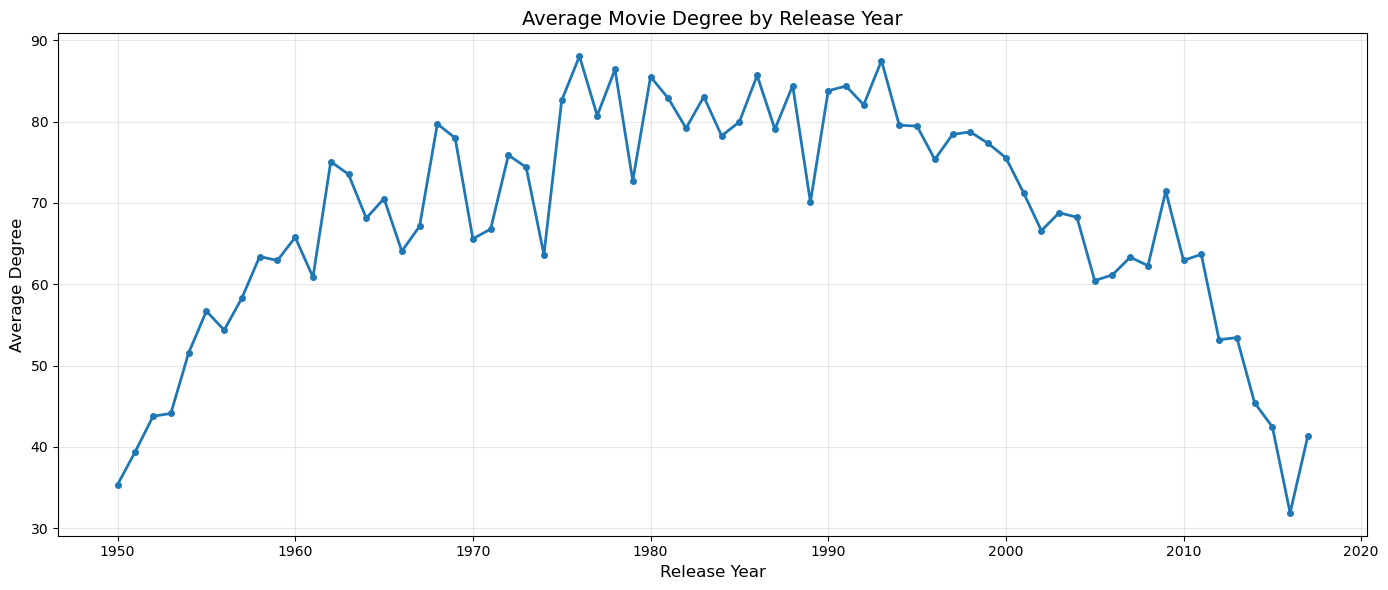

In [ ]:
# calculate average degree per release year
avg_degree_per_year = nodes_df.groupby("year").apply(
    lambda group: group["movie_id"].map(degree_dict).mean()
).reset_index()
avg_degree_per_year.columns = ["year", "avg_degree"]

plt.figure(figsize=(14, 6))
plt.plot(avg_degree_per_year["year"], avg_degree_per_year["avg_degree"], linewidth=2, marker='o', markersize=4)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average Degree", fontsize=12)
plt.title("Average Movie Degree by Release Year", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows that the most connected movies are between in the 70s, 80s and 90s.

To understand the reasons of this phenomenon, we perform a short analysis of the movie dataset.

In [101]:
#c ount movies per decade
df_clean['decade'] = (df_clean['Release Year'] // 10 * 10).astype(str) + '-' + ((df_clean['Release Year'] // 10 * 10) + 9).astype(str)

movies_per_decade = df_clean['decade'].value_counts().sort_index()

print("Movies per decade:")
for decade, count in movies_per_decade.items():
    print(f"{decade}: {count}")

Movies per decade:
1950-1959: 3103
1960-1969: 2319
1970-1979: 2173
1980-1989: 2842
1990-1999: 3930
2000-2009: 5002
2010-2019: 5834


In [102]:
# Count unique origins per decade
origins_per_decade = df_clean.groupby("decade")["Origin/Ethnicity"].nunique().reset_index()
origins_per_decade.columns = ["decade", "unique_origins"]

print("Unique origins per decade:")
origins_per_decade

Unique origins per decade:


,decade,unique_origins
0,1950-1959,8
1,1960-1969,10
2,1970-1979,14
3,1980-1989,12
4,1990-1999,16
5,2000-2009,19
6,2010-2019,23


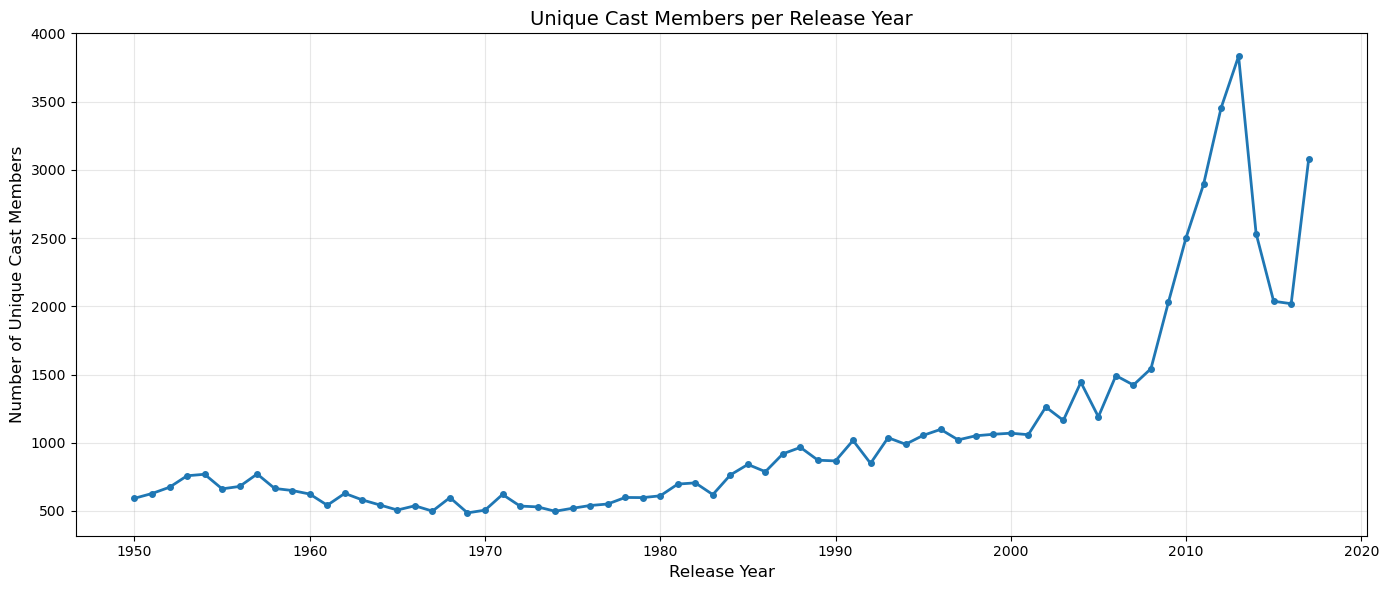

In [103]:
# Count unique cast members in every decade
year_cast_counts = {}

for year in df_clean['Release Year'].unique():
    df_year = df_clean[df_clean['Release Year'] == year]
    all_actors = []
    for cast_list in df_year['cast_list']:
        all_actors.extend(cast_list)
    unique_actors = set(all_actors)
    year_cast_counts[year] = len(unique_actors)

# Sort by year for better display
year_cast_counts = dict(sorted(year_cast_counts.items()))

# Plot unique cast members per release year
years = sorted(year_cast_counts.keys())
counts = [year_cast_counts[year] for year in years]

plt.figure(figsize=(14, 6))
plt.plot(years, counts, linewidth=2, marker='o', markersize=4)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Unique Cast Members", fontsize=12)
plt.title("Unique Cast Members per Release Year", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

It can be observed that even though there are significantly more movies in the last two decades (5000 per decade compared to 2000 in 60s and 70s), these movies tend to be less connected. It can be caused by the new film markets emerging in the different countries, that make the actors network more sparse and layed out across the globe. The sharp increase in the number of the actors in the the network around the year 2010 also suggests the professional network of actors grew bigger and it is more difficult for them to overlap in many productions.

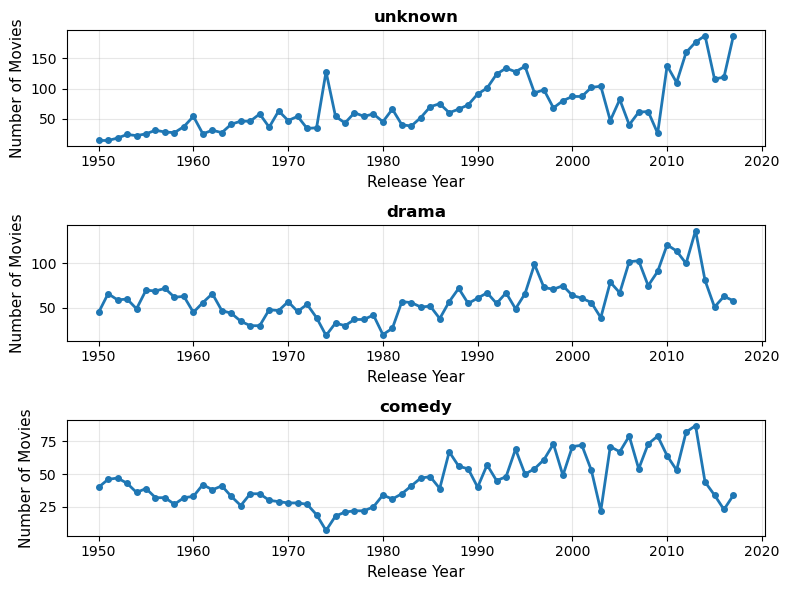

In [112]:
top_3_genres = df_clean['Genre'].value_counts().head(3).index.tolist()

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

for idx, genre in enumerate(top_3_genres):
    # Filter movies by genre and count per year
    df_genre = df_clean[df_clean['Genre'] == genre]
    genre_per_year = df_genre['Release Year'].value_counts().sort_index()
    
    # Plot
    axes[idx].plot(genre_per_year.index, genre_per_year.values, linewidth=2, marker='o', markersize=4)
    axes[idx].set_xlabel('Release Year', fontsize=11)
    axes[idx].set_ylabel('Number of Movies', fontsize=11)
    axes[idx].set_title(f'{genre}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Communities Analysis

In [108]:
df_communites = nodes_df.copy()

In [109]:
df_communites

,movie_id,community,title,year,genre,director,cast,origin,plot
0,0,0,711 Ocean Drive,1950,crime drama,Joseph M. Newman,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",American,Knowing how much telephone repairman Mal Grang...
1,1,0,Abbott and Costello in the Foreign Legion,1950,comedy,Charles Lamont,"[Abbott and Costello, Patricia Medina]",American,Bud Jones (Bud Abbott) and Lou Hotchkiss (Lou ...
2,2,0,The Admiral Was a Lady,1950,comedy,Albert S. Rogell,"[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",American,"After the end of World War II, Jean Madison (W..."
3,3,0,All About Eve,1950,drama,Joseph L. Mankiewicz,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",American,Margo Channing (Bette Davis) is one of the big...
4,4,0,American Guerrilla in the Philippines,1950,war,Fritz Lang,"[Tyrone Power, Micheline Presle]",American,"In April 1942 in the Philippines, an American ..."
...,...,...,...,...,...,...,...,...,...
24055,25149,18,1987: When the Day Comes,2017,unknown,Jang Joon-hwan,"[Kim Yoon-seok, Ha Jung-woo, Yoo Hae-jin, Kim ...",South_Korean,Based on real life events surrounding the June...
24056,25161,1,Yahşi Batı,2010,comedy,Ömer Faruk Sorak,"[Cem Yılmaz, Demet Evgar & Özkan Uğur]",Turkish,"Two special agents, Aziz and Lemi, are tasked ..."
24057,25187,0,Signora Enrica,2011,comedy-drama,Ali İlhan,"[Claudia Cardinale, İsmail Hacıoğlu & Fahriye ...",Turkish,"Abandoned with a son by her husband years ago,..."
24058,25193,1,Once Upon a Time in Anatolia,2011,drama,Nuri Bilge Ceylan,"[Yılmaz Erdoğan, Taner Birsel & Ufuk Karaali]",Turkish,"Through the night, three cars carry a small gr..."


In [114]:
# Get the size of each community
community_sizes = df_communites["community"].value_counts().sort_index().reset_index()
community_sizes.columns = ["community", "size"]

# Sort by size in descending order
community_sizes = community_sizes.sort_values("size", ascending=False).reset_index(drop=True)

print("Community sizes (sorted by size):")
display(community_sizes)

Community sizes (sorted by size):


,community,size
0,1,8167
1,0,5346
2,26,4185
3,16,2812
4,11,955
5,31,825
6,18,768
7,19,324
8,4,191
9,30,134


**For the analysis we will take only the 12 biggest communities (the top 12 in the listed communities above).**

In [119]:
df_communites['origin'].unique()

array(['American', 'Australian', 'Bangladeshi', 'British', 'Canadian',
       'Chinese', 'Egyptian', 'Hong Kong', 'Filipino', 'Assamese',
       'Bengali', 'Bollywood', 'Kannada', 'Malayalam', 'Marathi',
       'Punjabi', 'Tamil', 'Telugu', 'Japanese', 'Malaysian', 'Russian',
       'South_Korean', 'Turkish'], dtype=object)

In [149]:
df_communites['genre'].nunique()

1848

### Confusion matrices

To identify what group of movies each community represents, we compute confusion matrices for two characteristics: origin and genre. We consider only 30 the most common genres, as it would be difficult to perform a meaningful analysis with all unique genres (1848 unique values).

In [ ]:
# top 12 communities
top_12_communities = community_sizes.head(12)["community"].tolist()
n_communities = len(top_12_communities)

def confusion_matrix_community_attribute(df, attribute, communities_list):
    
    # Get unique values for the attribute
    unique_values = sorted(df[attribute].unique())
    
    # Initialize confusion matrix
    confusion_matrix = pd.DataFrame(0, index=communities_list, columns=unique_values)
    
    # Fill the matrix
    for _, row in df.iterrows():
        comm = row["community"]
        attr_val = row[attribute]
        if comm in communities_list:
            confusion_matrix.loc[comm, attr_val] += 1
    
    return confusion_matrix



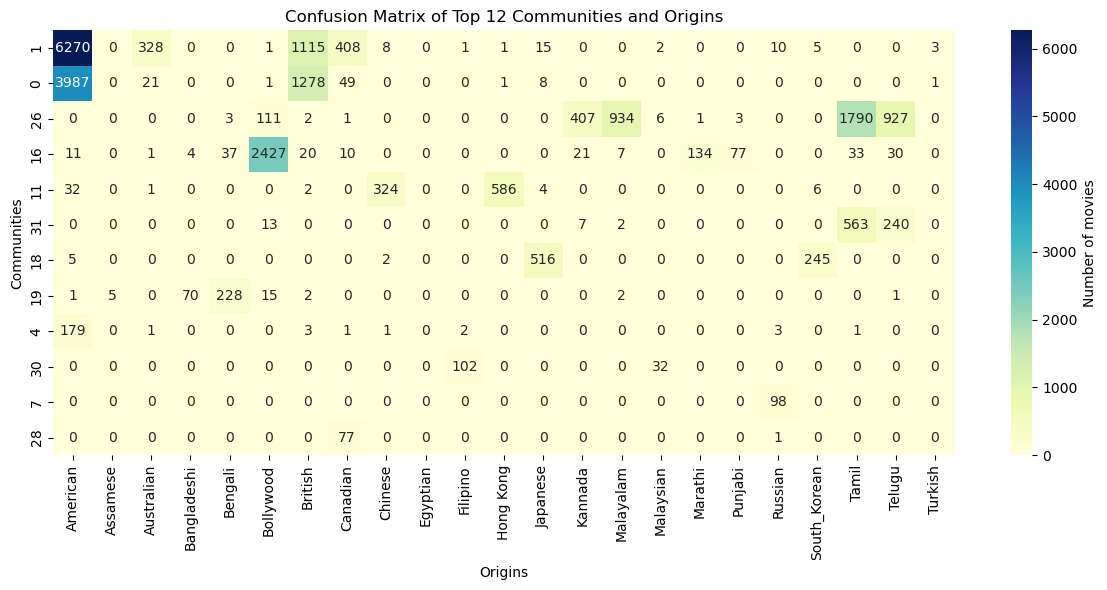

In [142]:
# origin conf matrix
cm_origins = confusion_matrix_community_attribute(df_communites, "origin", top_12_communities)

plt.figure(figsize=(12, 6))
sns.heatmap(cm_origins, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={"label": "Number of movies"})
plt.ylabel("Communities")
plt.xlabel("Origins")
plt.title("Confusion Matrix of Top 12 Communities and Origins")
plt.tight_layout()
plt.show()


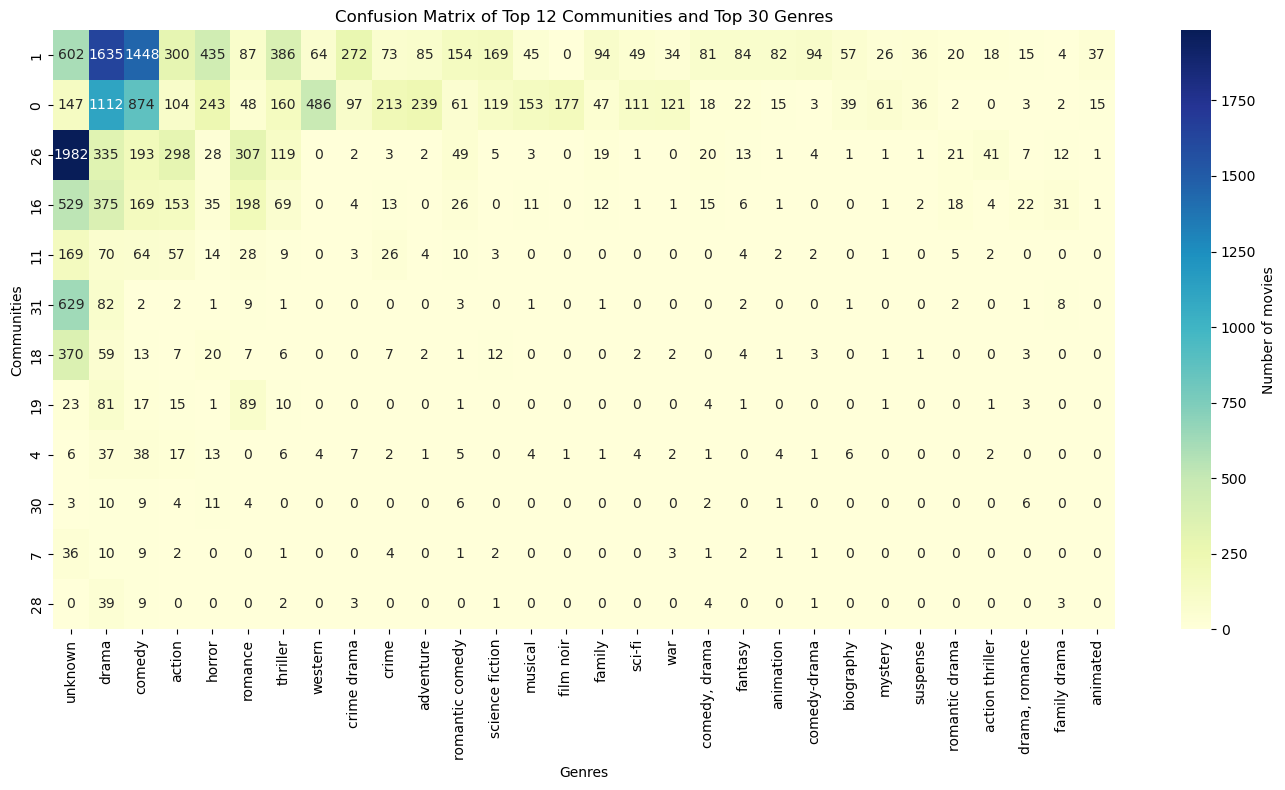

In [147]:
# we take only 30 most frequent genres, because there are too many unique 
top_30_genres = df_communites["genre"].value_counts().head(30).index.tolist()
cm_genres = confusion_matrix_community_attribute(df_communites, "genre", top_12_communities)
cm_genres = cm_genres[top_30_genres]

plt.figure(figsize=(14, 8))
sns.heatmap(cm_genres, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={"label": "Number of movies"})
plt.ylabel("Communities")
plt.xlabel("Genres")
plt.title("Confusion Matrix of Top 12 Communities and Top 30 Genres")
plt.tight_layout()
plt.show()

Based on the confusion matrices an initial overview of the communities can be built:
- Community 1: English speaking movies (American, British, Australian, Canadian) of all genres, but drama and comedy strongly dominates

- Community 0: American and British movies of all genres, also drama and comedy strongly dominates but less than in Community 1
- Community 26: Indian languages movies of mostly unknown genres
- Community 16: Bollywood movies
- Community 11: Hong Kong and Chinese movies 
- Community 31: Smaller group of Indian languages movies of mostly unknown genres
- Community 18: Japanese and South Korean movies of mostly unknown genres
- Community 19: Bengali and Bangladeshi movies
- Community 4: Small subset of American movies
- Community 30: Filipino and Malayesian movies
- Community 7: Russian movies
- Community 28: Canadian movies

Overall, the communities are grouped around the origin/ethnicity of the movies. Furhter analysis will focus on the plots that films within different communities have.

### Visualization

To better understand the communities in the movie network, we visualize them.

In [154]:
import libs.backboning as backboning
import matplotlib.patches as mpatches


Below functions are strongly inspired by the functions from our Assignment 2.

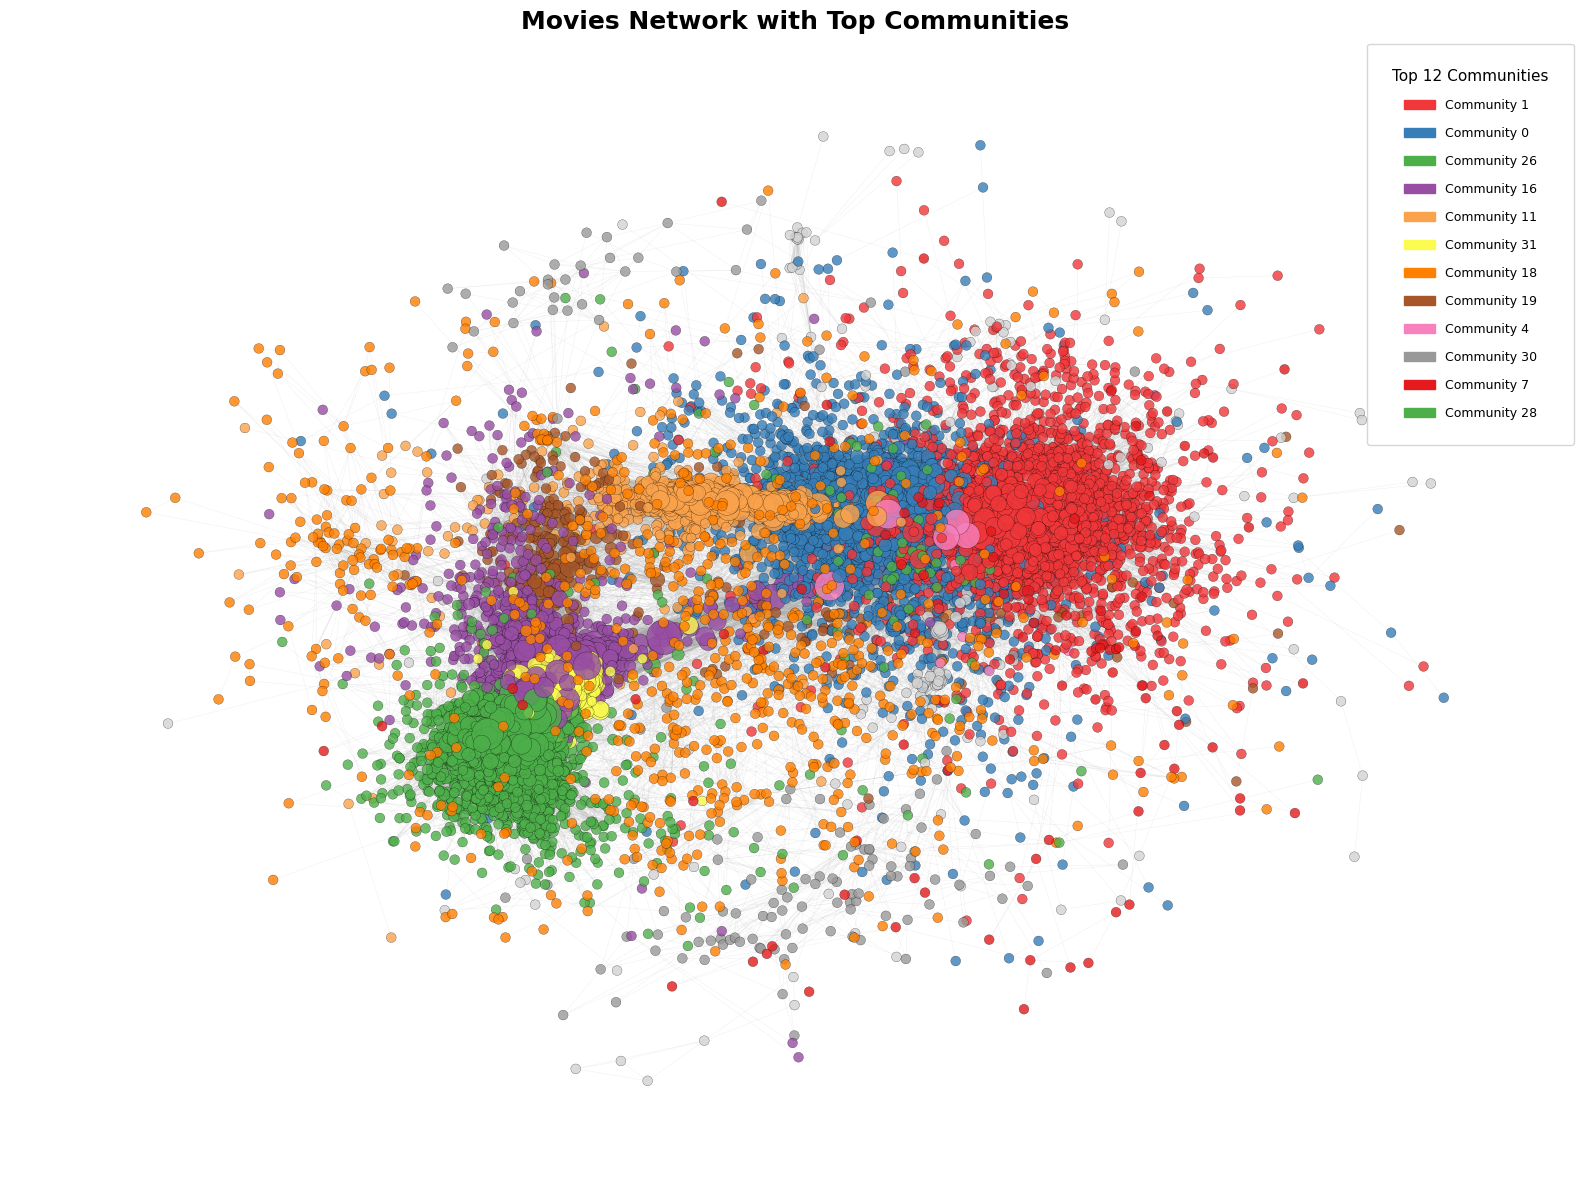

In [156]:
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

def draw_graph_with_communities(G_undirected, pos, communities_dict, top_communities_list, title="Movies Network with Communities"):
    """
    Draw network graph with community coloring.
    
    Parameters:
    - G_undirected: NetworkX graph
    - pos: node positions dictionary
    - communities_dict: dict mapping node to community ID
    - top_communities_list: list of community IDs to highlight
    - title: plot title
    """
    
    # Manage node sizes based on degree
    deg_dict = dict(G_undirected.degree())
    node_sizes = [max(50, d * 2) for d in deg_dict.values()]
    
    # Custom color palette for top 12 communities
    custom_colors = [
        "#f0373a", "#377eb8", "#4daf4a", "#984ea3", "#fba34c", "#fbfb50",
        "#ff7f00", "#a65628", "#f781bf", "#999999", "#e41a1c", "#4daf4a"
    ]
    
    # Create community to color mapping
    community_to_color = {comm: custom_colors[idx] for idx, comm in enumerate(top_communities_list)}
    
    # Assign colors to nodes
    node_colors = []
    for node in G_undirected.nodes():
        comm = communities_dict.get(node)
        if comm in community_to_color:
            node_colors.append(community_to_color[comm])
        else:
            node_colors.append("#d3d3d3")  # Gray for other communities
    
    # Create legend patches
    legend_patches = [
        mpatches.Patch(color=custom_colors[idx], label=f"Community {comm}")
        for idx, comm in enumerate(top_communities_list)
    ]
    
    # Draw the graph
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(G_undirected, pos, node_color=node_colors, node_size=node_sizes, 
                          linewidths=0.2, edgecolors='black', alpha=0.8)
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.2, width=0.3, edge_color="#a9a9a9")
    
    plt.legend(
        handles=legend_patches, 
        title="Top 12 Communities", 
        fontsize=9,
        title_fontsize=11,
        loc='upper right', 
        markerscale=2,
        borderpad=2,
        labelspacing=1.2,
        handlelength=2.5
    )
    plt.axis('off')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Call the function with your data
draw_graph_with_communities(G, pos, partition, top_12_communities, 
                           title="Movies Network with Top Communities")

The code below plots the network with backboning for better visualization.

In [232]:
def backboning_graph(G, alpha_thresh):

    # Make sure the graph is undirected
    G_undirected = G.copy()
    
    # Compute edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G_undirected, normalized=False)
    
    # Normalize betweenness to weights [1, 100]
    betweenness_values = np.array(list(edge_betweenness.values()))
    if len(betweenness_values) > 0:
        normalized_weights = 1 + (betweenness_values - betweenness_values.min()) * (99 / (betweenness_values.max() - betweenness_values.min() + 1e-10))
    else:
        normalized_weights = np.array([])
    
    # Get edges and build weights dictionary
    edges = list(G_undirected.edges())
    normalized_weights_dict = {
        edge: float(normalized_weights[i]) for i, edge in enumerate(edges)
    }
    
    # Assign weights to edges
    nx.set_edge_attributes(G_undirected, normalized_weights_dict, "betweenness_weight")
    
    # Build edge dataframe for disparity filter
    edges_data = [(u, v, w['weight']) for u, v, w in G_undirected.edges(data=True)]
    df_edges = pd.DataFrame(edges_data, columns=['src', 'trg', 'nij'])
    
    # Apply the disparity filter
    df_backbone = backboning.disparity_filter(df_edges, undirected=True)
    df_backbone_filtered = df_backbone[df_backbone["score"] < alpha_thresh]
    
    # Reconstruct graph from backbone edges
    G_backbone = nx.Graph()
    
    # Add nodes with attributes
    for node in G.nodes():
        G_backbone.add_node(node, **dict(G.nodes[node]))
    
    # Add edges from backbone
    for _, row in df_backbone_filtered.iterrows():
        src, trg = int(row['src']), int(row['trg'])
        if G.has_edge(src, trg):
            G_backbone.add_edge(src, trg, weight=G[src][trg]['weight'], score=row['score'])
    
    return G_backbone

# Apply backboning with a chosen alpha threshold
alpha_threshold = 0.50
G_backbone = backboning_graph(G, alpha_threshold)

print("Original number of edges:", G.number_of_edges())
print("Number of edges in backbone:", G_backbone.number_of_edges())
print("Number of nodes in backbone:", G_backbone.number_of_nodes())

# Visualize the backbone with communities
pos_backbone = nx.spring_layout(G_backbone, k=0.5, iterations=50, seed=42)
draw_graph_with_communities(G_backbone, pos_backbone, partition, top_12_communities, 
                           title="Movie Network Backbone with Top 12 Communities")

KeyboardInterrupt: 

### Plot Sentiment Analysis

In this subsection we analyze the sentiment of the plots of the movies within the communities to identify any possible patterns.

Before the analysis the text of the plots needs to be cleaned, so we are sure, the analysis runs correctly. Then we calculate the sentiment score of every movie in the network using a wordlist from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Finally, we compute the average sentiment score in every community to compare them.

Plots quality check and clean-up

In [215]:
df_communites['plot'].isna().value_counts()

plot
False    24060
Name: count, dtype: int64

In [217]:
type(df_communites['plot'])

pandas.core.series.Series

In [218]:
plots = []

for plot_text in df_communites['plot']:
    text = str(plot_text)
    text = text.replace('\\n', ' ').replace('\\t', ' ')
    text = text.replace('\\', '')
    text = ' '.join(text.split())
    text = re.sub(r"\s+", " ", text).strip()

    plots.append(text)

'\\' in plots[0]


False

Functions for calculating the sentiment analysis of every movie. These functions are the same function that we created in the Assignment 2, only adapted to the new data formats.

In [ ]:
# functions for calculating the sentiment analysis of every movie

def tokenize_text(text):
    # tokenizes the plot text using the nltk library method word_tokenize()
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

def load_happiness_dict(filepath):
    # loads the LabMT dataset and creates a dictionary from the columns 'word' and 'happiness_average'
    df = pd.read_csv(filepath, sep='\t', skiprows=2)
    df = df[['word', 'happiness_average']]

    # drop any missing values just in case
    df = df.dropna(subset=['word', 'happiness_average'])

    happiness_dict = pd.Series(df.happiness_average.values, index=df.word).to_dict()

    return happiness_dict

def calculate_sentiment(tokens, happiness_dict):
    # implements the sentiment formula to get a sentiment (happiness) score

    # count frequencies of all tokens
    token_counts = Counter(tokens)

    numerator = 0.0
    denominator = 0

    for word, happiness_value in happiness_dict.items():
        if word in token_counts:
            freq = token_counts[word]
            numerator += happiness_value * freq
            denominator += freq

    if denominator == 0:
        return None

    return numerator / denominator

In [210]:
G_sentiment = G.copy()

The script below is a sequence of operations that calculate the sentiment score for every movie using the functions defined above.

In [ ]:
# a list of nodes for the iteration
nodes = set(G_sentiment.nodes())
    
labMT_filepath = 'Data_Set_S1.txt'

# Tokenize plots and store tokens by movie_id
movie_tokens = {}

for idx, plot_text in enumerate(plots):
    movie_id = df_communites.iloc[idx]['movie_id']
    if movie_id in nodes:
        tokens = tokenize_text(plot_text)
        movie_tokens[movie_id] = tokens

# Load the happiness dictionary
happiness_dict = load_happiness_dict(labMT_filepath)

# Calculate sentiment scores for each movie
sentiment_scores = {}
for movie_id, tokens in movie_tokens.items():
    sentiment = calculate_sentiment(tokens, happiness_dict)
    sentiment_scores[movie_id] = sentiment

print(f"Calculated sentiment scores for {len(sentiment_scores)} movies")


Calculated sentiment scores for 24060 movies


The next part calculates the average sentiment of each of the 12 communities.

In [ ]:
def calculate_community_sentiment(G, community_nodes, sentiment_scores):
    # calculates the average sentiment of the nodes in the community
    
    scores = [
        sentiment_scores[node] 
        for node in community_nodes 
        if node in sentiment_scores and sentiment_scores[node] is not None
    ]

    avg_sentiment = np.mean(scores) if len(scores) > 0 else None
    return avg_sentiment


# sll nodes for each community
communities_dict = {}
for comm_id in top_12_communities:
    communities_dict[comm_id] = [node for node in G_sentiment.nodes() if partition[node] == comm_id]

# calculate sentiment for each community
community_sentiments = {}
for comm_id in top_12_communities:
    community_nodes = communities_dict[comm_id]
    community_sentiment = calculate_community_sentiment(G_sentiment, community_nodes, sentiment_scores)
    community_sentiments[comm_id] = community_sentiment
    print(f'Community {comm_id} has an average sentiment: {community_sentiment:.4f}')

Community 1 has an average sentiment: 5.3493
Community 0 has an average sentiment: 5.3320
Community 26 has an average sentiment: 5.4025
Community 16 has an average sentiment: 5.3916
Community 11 has an average sentiment: 5.3333
Community 31 has an average sentiment: 5.4376
Community 18 has an average sentiment: 5.3381
Community 19 has an average sentiment: 5.4273
Community 4 has an average sentiment: 5.3299
Community 30 has an average sentiment: 5.3952
Community 7 has an average sentiment: 5.3510
Community 28 has an average sentiment: 5.3738


The average sentiment is almost the same for every community, what is not very suprising, since almost all communities consist of very diverse film genres, so there are no dominant emotions present in the communities movies plots.